In [1]:
import numpy as np
import pandas as pd

import h5py
import os
import sys
from tqdm import tqdm
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import gridspec

import astropy.units as u
import astropy.constants as C
import peters
from IPython.core.debugger import set_trace
from importlib import reload
            
colors = sns.color_palette("colorblind", n_colors=10)
colors = [colors[0], colors[2], colors[4], colors[1], colors[3], colors[6], colors[9], colors[5], colors[8]]

plt.style.use("../plot/.MATPLOTLIB_RCPARAMS.sty")

In [2]:
hyperparam_dict = {'p0':{0:r'$\chi_\mathrm{b}=0.0$', 1:r'$\chi_\mathrm{b}=0.1$', 2:r'$\chi_\mathrm{b}=0.2$', 3:r'$\chi_\mathrm{b}=0.5$'}, 
                   'p1':{0:r'$\alpha_\mathrm{CE}=0.2$', 1:r'$\alpha_\mathrm{CE}=0.5$', 2:r'$\alpha_\mathrm{CE}=1.0$', 3:r'$\alpha_\mathrm{CE}=2.0$', 4:r'$\alpha_\mathrm{CE}=5.0$'}, 
                   'beta_CE': r'$\beta_\mathrm{CE}$', 'beta_CHE': r'$\beta_\mathrm{CHE}$', 'beta_GC': r'$\beta_\mathrm{GC}$', 'beta_NSC': r'$\beta_\mathrm{NSC}$', 'beta_SMT': r'$\beta_\mathrm{SMT}$', 
                   'beta_CE_det': r'$\beta_\mathrm{CE}^\mathrm{det}$', 'beta_CHE_det': r'$\beta_\mathrm{CHE}^\mathrm{det}$', 'beta_GC_det': r'$\beta_\mathrm{GC}^\mathrm{det}$', \
                   'beta_NSC_det': r'$\beta_\mathrm{NSC}^\mathrm{det}$', 'beta_SMT_det': r'$\beta_\mathrm{SMT}^\mathrm{det}$'}

In [3]:
data_path = '/Users/michaelzevin/research/model_selection/model_selection/trials/gwobs_no190521'
data_path_CEGC = '/Users/michaelzevin/research/model_selection/model_selection/trials/gwobs_CEGC_no190521'
data_path_CESMT = '/Users/michaelzevin/research/model_selection/model_selection/trials/gwobs_CESMT_no190521'

fig_path = '/Users/michaelzevin/research/model_selection/model_selection/paper/figures/'

In [4]:
# get the hdf5 files for default runs
run_files = os.listdir(data_path)
sample_files = []
for file in run_files:
    if '.hdf5' in file:
        sample_files.append(file)
        
samples = pd.DataFrame()

for file in sample_files:
    tmp = pd.read_hdf(os.path.join(data_path, file), key='model_selection/samples')
    samples = samples.append(tmp)
    
samples = samples.reset_index(drop=True)


# also get detectable samples for this run
run_files = os.listdir(data_path)
sample_files = []
for file in run_files:
    if '.hdf5' in file:
        sample_files.append(file)

samples_detectable = pd.DataFrame()

for file in sample_files:
    tmp = pd.read_hdf(os.path.join(data_path, file), key='model_selection/detectable_samples')
    samples_detectable = samples_detectable.append(tmp)
    
samples_detectable = samples_detectable.reset_index(drop=True)



# get the hdf5 files for 2-channel runs
run_files = os.listdir(data_path_CEGC)
sample_files = []
for file in run_files:
    if '.hdf5' in file:
        sample_files.append(file)
        
samples_CEGC = pd.DataFrame()

for file in sample_files:
    tmp = pd.read_hdf(os.path.join(data_path_CEGC, file), key='model_selection/samples')
    samples_CEGC = samples_CEGC.append(tmp)
    
samples_CEGC = samples_CEGC.reset_index(drop=True)


# also get detectable samples for this run
run_files = os.listdir(data_path_CEGC)
sample_files = []
for file in run_files:
    if '.hdf5' in file:
        sample_files.append(file)
        
samples_CEGC_detectable = pd.DataFrame()

for file in sample_files:
    tmp = pd.read_hdf(os.path.join(data_path_CEGC, file), key='model_selection/detectable_samples')
    samples_CEGC_detectable = samples_CEGC_detectable.append(tmp)
    
samples_CEGC_detectable = samples_CEGC_detectable.reset_index(drop=True)



# get the hdf5 files for the 2-channel CESMT run
run_files = os.listdir(data_path_CESMT)
sample_files = []
for file in run_files:
    if '.hdf5' in file:
        sample_files.append(file)
        
samples_CESMT = pd.DataFrame()

for file in sample_files:
    tmp = pd.read_hdf(os.path.join(data_path_CESMT, file), key='model_selection/samples')
    samples_CESMT = samples_CESMT.append(tmp)
    
samples_CESMT = samples_CESMT.reset_index(drop=True)

In [5]:
def twochannel_branching_fractions(samples, hyperidx, prior_path, detectable=False, labelsize=40, ticksize=30, legendsize=25):
    beta_keys = sorted([key for key in list(samples.keys()) if 'beta' in key])
    hyperidx_key = 'p'+str(int(hyperidx))

    
    fig = plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(2,2, hspace=0.45)
    
    beta_axs = []
    for idx in np.arange(len(beta_keys)):
        beta_axs.append(fig.add_subplot(gs[0,idx]))

    Bmax_ax = fig.add_subplot(gs[1,:])
    

    ### TOP ROW
    # loop through hyperparameter values
    for (hkey, hval) in hyperparam_dict[hyperidx_key].items():
        samples_in_hypermodel = samples.loc[samples[hyperidx_key]==hkey]

        # loops through channels
        for idx, beta in enumerate(beta_keys):
        
            med = np.median(samples_in_hypermodel[beta])
            low90 = np.percentile(samples_in_hypermodel[beta],5)
            high90 = np.percentile(samples_in_hypermodel[beta],95)
            print("  {:s} ({:s}): {:0.3f}-{:0.3f}+{:0.3f}".format(beta, hval, med, med-low90, high90-med))
            
            if idx==0:
                h, bins = np.histogram(samples_in_hypermodel[beta], bins=100, range=(0,1))
                h = np.append(h, [0])
                beta_axs[idx].step(bins, h/len(samples), lw=4, alpha=0.5, color=colors[hkey], label=hval)
            else:
                h, bins = np.histogram(samples_in_hypermodel[beta], bins=100, range=(0,1))
                h = np.append(h, [0])
                beta_axs[idx].step(bins, h/len(samples), lw=4, alpha=0.5, color=colors[hkey])
                
                
    # plot total branching fraction
    for idx, beta in enumerate(beta_keys):
        h, bins = np.histogram(samples[beta], bins=100, range=(0,1))
        h = np.append(h, [0])
        beta_axs[idx].step(bins, h/len(samples), color='k', alpha=1.0, lw=3, linestyle='--', zorder=-10)
        med = np.median(samples[beta])
        low90 = np.percentile(samples[beta],5)
        high90 = np.percentile(samples[beta],95)
        print("{:s}: {:0.3f}-{:0.3f}+{:0.3f}".format(beta, med, med-low90, high90-med))
    
    
    # format plot
    for idx, ax in enumerate(beta_axs):
        
        ax.set_xlim(0,1)
        ax.set_xticks((0.0, 0.25, 0.5, 0.75, 1.0))
        ax.set_yscale('log')
        ax.set_ylim(1e-5, 1e-1)
        ax.set_yticks((1e-5, 1e-4, 1e-3, 1e-2, 1e-1))
        
        ax.set_xlabel(hyperparam_dict[beta_keys[idx]], fontsize=labelsize, labelpad=8)
        if idx==0:
            ax.set_ylabel(r'$p(\beta)$', fontsize=labelsize)
        else:
            ax.set_yticklabels([])
        ax.tick_params(axis='both', labelsize=ticksize)
        
    # legend
    if hyperidx_key=='p0':
        fig.legend(bbox_to_anchor=(0.52, 0.91), loc='center', ncol=2, prop={'size':legendsize})
    elif hyperidx_key=='p1':
        fig.legend(bbox_to_anchor=(0.45, 1.0), loc='center', ncol=len(hyperparam_dict[hyperidx_key].keys()), prop={'size':legendsize})
        
            
    ### BOTTOM ROW
    
    # get max beta for all samples
    betas = samples[beta_keys]
    max_betas = betas.max(axis=1)
    h, bins = np.histogram(max_betas, bins=100, range=(0,1))
    h = np.append(h[0], h)
    Bmax_ax.step(bins, h/len(samples), color='k', alpha=1.0, lw=3, linestyle='--', label='posterior')
    Bmax_ax.axvline(np.percentile(max_betas, 5), color='k', alpha=1.0, lw=3, linestyle='--')
    Bmax_ax.axvline(np.percentile(max_betas, 95), color='k', alpha=1.0, lw=3, linestyle='--')
    print("Maximum beta is <{:0.3f} at the 90% credible level".format(np.percentile(max_betas, 90)))
    print("Maximum beta is <{:0.3f} at the 99% credible level".format(np.percentile(max_betas, 99)))
    
    # get max beta for prior samples
    if detectable==True:
        prior_samps = pd.read_hdf(prior_path, key='detectable_samples')
    else:
        prior_samps = pd.read_hdf(prior_path, key='samples')
    beta_keys = [key for key in prior_samps.keys() if 'beta' in key]
    prior_samps = prior_samps[beta_keys]
    
    max_betas = prior_samps.max(axis=1)
    h, bins = np.histogram(max_betas, bins=100, range=(0,1))
    h = np.append(h[0], h)
    Bmax_ax.step(bins, h/len(samples), color='k', alpha=0.4, lw=3, label='prior')
    Bmax_ax.axvline(np.percentile(max_betas, 5), color='k', alpha=0.4, lw=3)
    Bmax_ax.axvline(np.percentile(max_betas, 95), color='k', alpha=0.4, lw=3)

    
    # get max betas for submodels
    for (hkey, hval) in hyperparam_dict[hyperidx_key].items():
        samples_in_hypermodel = samples.loc[samples[hyperidx_key]==hkey]
        betas = samples_in_hypermodel[beta_keys]
        max_betas = betas.max(axis=1)
        h, bins = np.histogram(max_betas, bins=100, range=(0,1))
        h = np.append(h[0], h)
        Bmax_ax.step(bins, h/len(samples), color=colors[hkey], alpha=0.7, lw=4)
        
    # format plot
    Bmax_ax.set_xlim(1/len(beta_keys),1)
    Bmax_ax.set_xticks((np.linspace(1/len(beta_keys), 1, 5)))
    Bmax_ax.set_ylim(0, 0.084)
    Bmax_ax.set_yticks((0, 0.02, 0.04, 0.06, 0.08))

    Bmax_ax.set_xlabel(r'$\beta_{\rm max}$', fontsize=labelsize, labelpad=8)
    Bmax_ax.set_ylabel(r'$p(\beta_{\rm max})$', fontsize=labelsize)
    Bmax_ax.tick_params(axis='both', labelsize=ticksize)
    
    Bmax_ax.legend(prop={'size': legendsize-4}, loc='center', bbox_to_anchor=(0.2, 0.71))
    
        
    # print Bayes factors
    samples0 = samples.loc[samples[hyperidx_key]==0]
    for (hkey, hval) in hyperparam_dict[hyperidx_key].items():
        samples_in_hypermodel = samples.loc[samples[hyperidx_key]==hkey]
        BF = len(samples_in_hypermodel) / len(samples0)
        print("   For {:s} model, BF={:0.5f}".format(hval,BF))
        
    
            
    plt.subplots_adjust(left=0.14, bottom=0.14, top=0.83, right=0.96)
    
    plt.savefig(os.path.join(fig_path, 'beta_CEGC.png'), dpi=200)

  beta_CE ($\chi_\mathrm{b}=0.0$): 0.907-0.106+0.053
  beta_GC ($\chi_\mathrm{b}=0.0$): 0.093-0.053+0.106
  beta_CE ($\chi_\mathrm{b}=0.1$): 0.854-0.160+0.078
  beta_GC ($\chi_\mathrm{b}=0.1$): 0.146-0.078+0.160
  beta_CE ($\chi_\mathrm{b}=0.2$): 0.783-0.598+0.115
  beta_GC ($\chi_\mathrm{b}=0.2$): 0.217-0.115+0.598
  beta_CE ($\chi_\mathrm{b}=0.5$): 0.257-0.232+0.378
  beta_GC ($\chi_\mathrm{b}=0.5$): 0.743-0.378+0.232
beta_CE: 0.891-0.224+0.065
beta_GC: 0.109-0.065+0.224
Maximum beta is <0.946 at the 90% credible level
Maximum beta is <0.971 at the 99% credible level
   For $\chi_\mathrm{b}=0.0$ model, BF=1.00000
   For $\chi_\mathrm{b}=0.1$ model, BF=0.24040
   For $\chi_\mathrm{b}=0.2$ model, BF=0.14519
   For $\chi_\mathrm{b}=0.5$ model, BF=0.02616


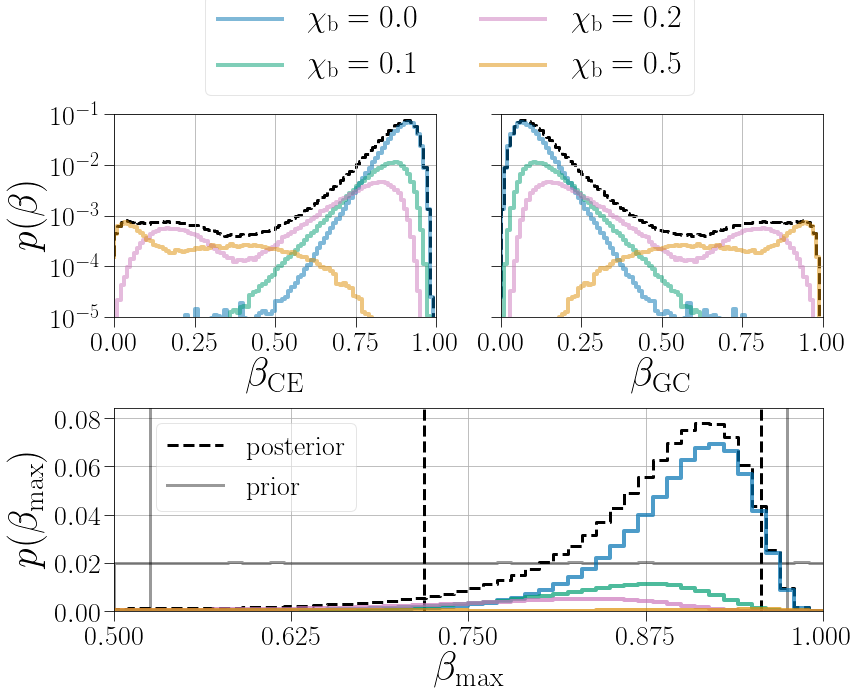

In [6]:
twochannel_branching_fractions(samples_CEGC, 0, \
                         prior_path='/Users/michaelzevin/research/model_selection/model_selection/data/beta_prior/prior_samples_2channel.hdf5', \
                              detectable=False, labelsize=40, ticksize=28, legendsize=32)

In [7]:
# print BFs for CESMT runs
print('Bayes factors for CESMT run...')

# print Bayes factors
samples0 = samples_CESMT.loc[samples_CESMT['p1']==2]
for (hkey, hval) in hyperparam_dict['p1'].items():
    samples_in_hypermodel = samples_CESMT.loc[samples_CESMT['p1']==hkey]
    BF = len(samples_in_hypermodel) / len(samples0)
    print("   For {:s} model, BF={:0.5f}".format(hval,BF))


Bayes factors for CESMT run...
   For $\alpha_\mathrm{CE}=0.2$ model, BF=0.99480
   For $\alpha_\mathrm{CE}=0.5$ model, BF=88.49973
   For $\alpha_\mathrm{CE}=1.0$ model, BF=1.00000
   For $\alpha_\mathrm{CE}=2.0$ model, BF=0.00000
   For $\alpha_\mathrm{CE}=5.0$ model, BF=0.00000


In [8]:
def branching_fractions(samples, labelsize=40, ticksize=30, legendsize=25, detectable=False):
    beta_keys = sorted([key for key in list(samples.keys()) if 'beta' in key])
    hyperidx_keys = sorted([key for key in list(samples.keys()) if 'beta' not in key])
    
    fig = plt.figure(figsize=(20,10))
    gs = gridspec.GridSpec(len(hyperidx_keys), len(beta_keys), hspace=0.8)
    
    for hidx, hyperparam in enumerate(hyperidx_keys):
        subaxs = []
        for idx in np.arange(len(beta_keys)):
            subaxs.append(fig.add_subplot(gs[hidx, idx]))
            
        if hidx==0:
            colors_tmp = colors[:4]
        elif hidx==1:
            colors_tmp = colors[4:][::-1]
    
        # loop through hyperparameter values
        for (hkey, hval) in hyperparam_dict[hyperparam].items():
            samples_in_hypermodel = samples.loc[samples[hyperparam]==hkey]

            # loops through channels
            for idx, beta in enumerate(beta_keys):
                if idx==2:
                    h, bins = np.histogram(samples_in_hypermodel[beta], bins=100, range=(0,1))
                    h = np.append(h, [0])
                    subaxs[idx].step(bins, h/len(samples), lw=4, alpha=0.5, color=colors_tmp[hkey], label=hval)
                else:
                    h, bins = np.histogram(samples_in_hypermodel[beta], bins=100, range=(0,1))
                    h = np.append(h, [0])
                    subaxs[idx].step(bins, h/len(samples), lw=4, alpha=0.5, color=colors_tmp[hkey])
                    
        # plot total branching fraction
        for idx, beta in enumerate(beta_keys):
            h, bins = np.histogram(samples[beta], bins=100, range=(0,1))
            h = np.append(h, [0])
            subaxs[idx].step(bins, h/len(samples), color='k', alpha=1.0, lw=3, linestyle='--', zorder=-10)
            if hidx==0:
                median = np.median(samples[beta])
                low90 = np.percentile(samples[beta],5)
                high90 = np.percentile(samples[beta],95)
                print("{:s}: {:0.3f}-{:0.3f}+{:0.3f}".format(beta,median, \
                            median-low90, high90-median))
                print("   First percentile: {:0.3f}".format(np.percentile(samples[beta], 1)))
                print("   Tenth percentile: {:0.3f}".format(np.percentile(samples[beta], 10)))
                print("   Percent level constraint: {:0.3f}, {:0.3f}".format(100*np.abs((low90-median)/median), 100*np.abs((high90-median)/median)))
            
            
        # format plot
        for idx, ax in enumerate(subaxs):

            ax.set_xlim(0,1)
            ax.set_yscale('log')
            ax.set_ylim(1e-7, 2e-1)
            ax.set_yticks((1e-7, 1e-5, 1e-3, 1e-1))

            ax.set_xticks((0.0, 0.5, 1.0))
            if detectable==True:
                ax.set_xlabel(hyperparam_dict[beta_keys[idx]+'_det'], fontsize=labelsize, labelpad=5)
            else:
                ax.set_xlabel(hyperparam_dict[beta_keys[idx]], fontsize=labelsize, labelpad=5)
                
            if idx==0:
                if detectable==True:
                    ax.set_ylabel(r'$p(\beta^\mathrm{det})$', fontsize=labelsize)
                else:
                    ax.set_ylabel(r'$p(\beta)$', fontsize=labelsize)
            else:
                ax.set_yticklabels([])
            ax.tick_params(axis='both', labelsize=ticksize)
                
        if hyperparam=='p0':
            subaxs[2].legend(prop={'size':legendsize}, loc='center', bbox_to_anchor=(0.5, 1.2), ncol=5)
        elif hyperparam=='p1':
            subaxs[2].legend(prop={'size':legendsize}, loc='center', bbox_to_anchor=(0.5, 1.2), ncol=5)
            
            
    # print info for paper
    print("")
    if detectable==False:
        for beta in ['beta_GC', 'beta_NSC']:
            print("Beta increase from chi00 to chi05 in {}, {:0.3f}".format(beta, \
                np.median(samples.loc[samples['p0']==3][beta])-np.median(samples.loc[samples['p0']==0][beta])))
        for beta in ['beta_CE']:
            print("Beta increase from alpha20 to alpha02 in {}, {:0.3f}".format(beta, \
                np.median(samples.loc[samples['p1']==3][beta])-np.median(samples.loc[samples['p1']==0][beta])))
    if detectable==True:
        print("BetaSMT for chib=0.0: {:0.3f}".format(np.median(samples.loc[samples['p0']==0]['beta_SMT'])))
        
    # print Bayes factors for spin and alpha models
    print("")
    samples0 = samples.loc[samples['p0']==0]
    for (hkey, hval) in hyperparam_dict['p0'].items():
        samples_in_hypermodel = samples.loc[samples['p0']==hkey]
        BF = len(samples_in_hypermodel) / len(samples0)
        print("For {:s} model, BF={:0.5f}".format(hval,BF))
    samples0 = samples.loc[samples['p1']==2]
    for (hkey, hval) in hyperparam_dict['p1'].items():
        samples_in_hypermodel = samples.loc[samples['p1']==hkey]
        BF = len(samples_in_hypermodel) / len(samples0)
        print("For {:s} model, BF={:0.5f}".format(hval,BF))
    # print BF of low spins relative to high spins
    samples_lowspin = samples.loc[(samples['p0']==0) | (samples['p0']==1)]
    samples_highspin = samples.loc[(samples['p0']==2) | (samples['p0']==3)]
    BF = len(samples_lowspin) / len(samples_highspin)
    print("\nSpins of <0.1 are preferred relative to spins >0.2 by BF={:0.5f}".format(BF))
        
    plt.subplots_adjust(left=0.08, right=0.97)
    if detectable==False:
        plt.savefig(os.path.join(fig_path, 'beta_posteriors.png'), dpi=200)
    elif detectable==True:
        plt.savefig(os.path.join(fig_path, 'beta_posteriors_detectable.png'), dpi=200)
    

beta_CE: 0.708-0.604+0.193
   First percentile: 0.024
   Tenth percentile: 0.209
   Percent level constraint: 85.308, 27.280
beta_CHE: 0.023-0.018+0.058
   First percentile: 0.002
   Tenth percentile: 0.007
   Percent level constraint: 78.182, 255.746
beta_GC: 0.114-0.091+0.298
   First percentile: 0.007
   Tenth percentile: 0.035
   Percent level constraint: 80.221, 261.835
beta_NSC: 0.024-0.021+0.105
   First percentile: 0.001
   Tenth percentile: 0.006
   Percent level constraint: 87.028, 433.849
beta_SMT: 0.100-0.090+0.365
   First percentile: 0.002
   Tenth percentile: 0.020
   Percent level constraint: 89.320, 364.195

Beta increase from chi00 to chi05 in beta_GC, 0.506
Beta increase from chi00 to chi05 in beta_NSC, 0.180
Beta increase from alpha20 to alpha02 in beta_CE, 0.629

For $\chi_\mathrm{b}=0.0$ model, BF=1.00000
For $\chi_\mathrm{b}=0.1$ model, BF=0.52640
For $\chi_\mathrm{b}=0.2$ model, BF=0.08163
For $\chi_\mathrm{b}=0.5$ model, BF=0.03678
For $\alpha_\mathrm{CE}=0.2$ 

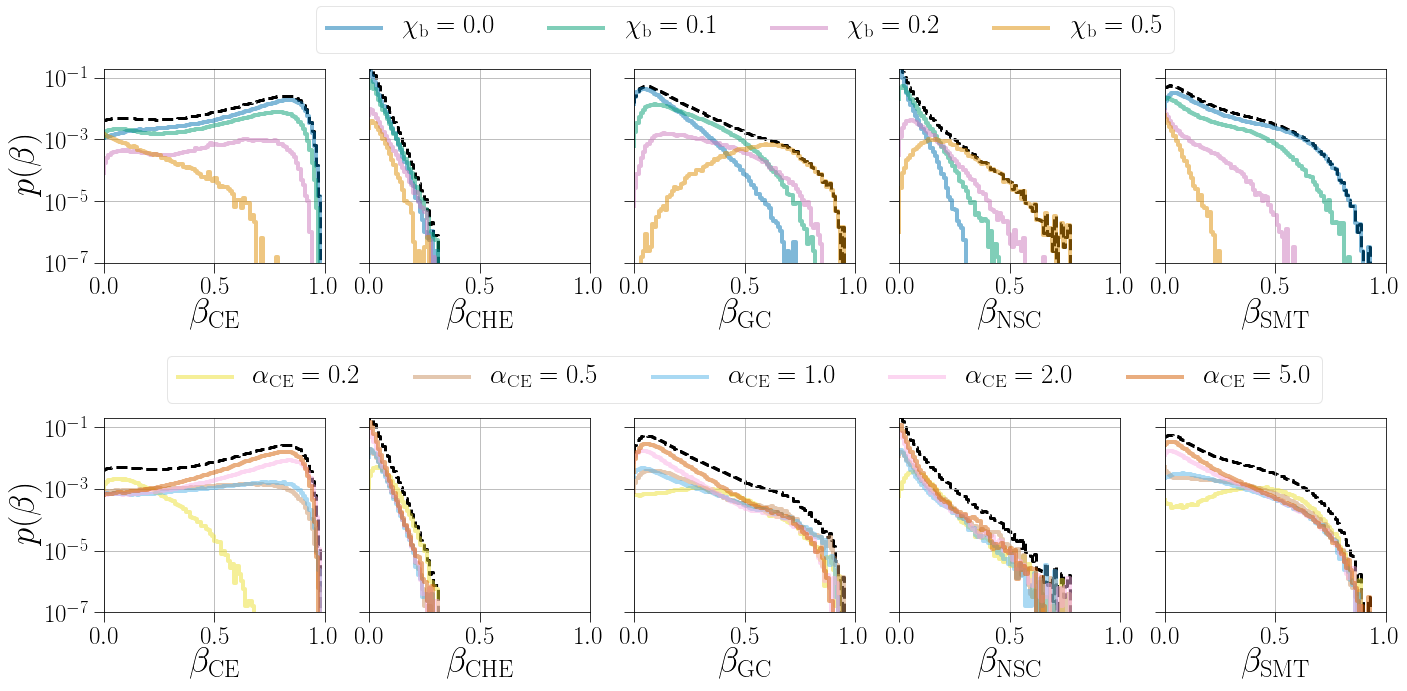

In [9]:
branching_fractions(samples, labelsize=35, ticksize=25, legendsize=27, detectable=False)

beta_CE: 0.083-0.074+0.180
   First percentile: 0.002
   Tenth percentile: 0.017
   Percent level constraint: 89.702, 217.703
beta_CHE: 0.109-0.080+0.124
   First percentile: 0.011
   Tenth percentile: 0.042
   Percent level constraint: 73.855, 113.909
beta_GC: 0.302-0.221+0.260
   First percentile: 0.026
   Tenth percentile: 0.122
   Percent level constraint: 73.129, 86.082
beta_NSC: 0.186-0.155+0.255
   First percentile: 0.007
   Tenth percentile: 0.054
   Percent level constraint: 83.478, 137.295
beta_SMT: 0.264-0.235+0.265
   First percentile: 0.005
   Tenth percentile: 0.060
   Percent level constraint: 88.964, 100.469

BetaSMT for chib=0.0: 0.328

For $\chi_\mathrm{b}=0.0$ model, BF=1.00000
For $\chi_\mathrm{b}=0.1$ model, BF=0.52640
For $\chi_\mathrm{b}=0.2$ model, BF=0.08163
For $\chi_\mathrm{b}=0.5$ model, BF=0.03678
For $\alpha_\mathrm{CE}=0.2$ model, BF=0.47371
For $\alpha_\mathrm{CE}=0.5$ model, BF=1.04006
For $\alpha_\mathrm{CE}=1.0$ model, BF=1.00000
For $\alpha_\mathrm{C

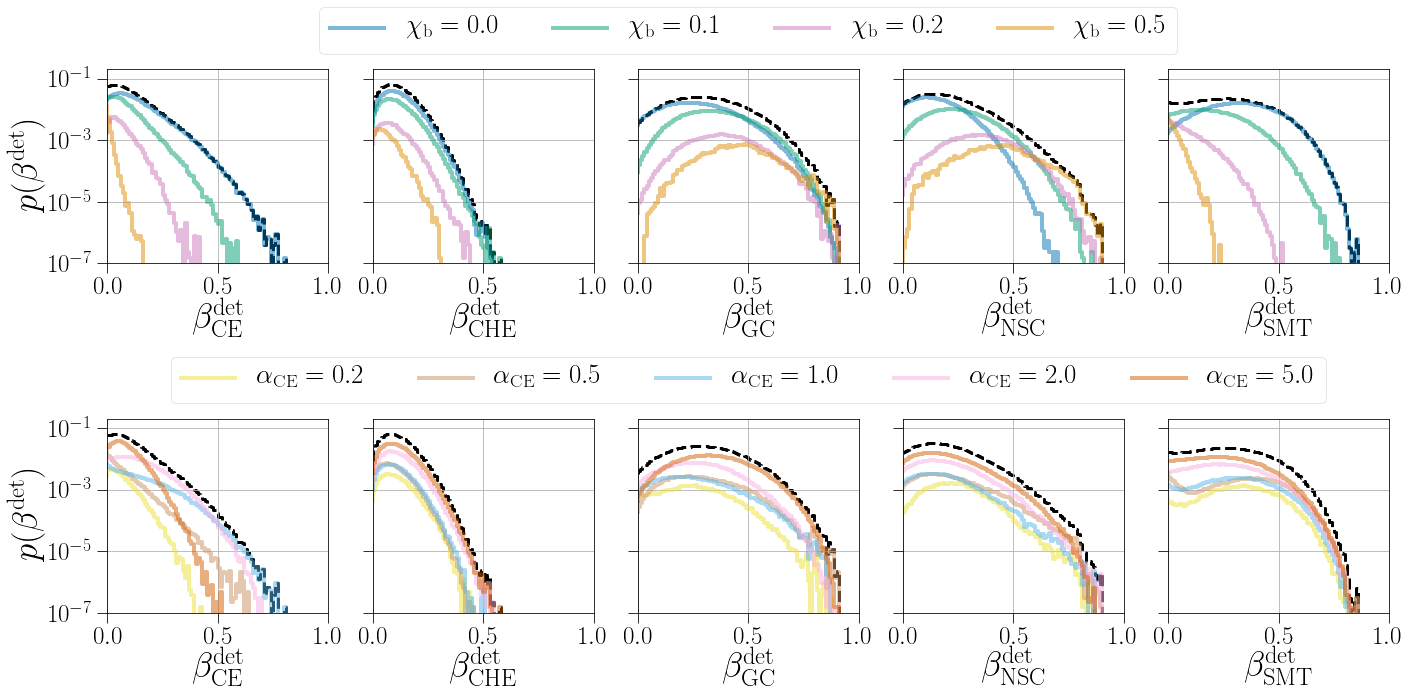

In [10]:
branching_fractions(samples_detectable, labelsize=35, ticksize=25, legendsize=27, detectable=True)

In [11]:
# print stuff for paper comparing 2-channel and 5-channel analyses
def perc_diff(a,b):
    return 100*np.abs((b-a)/a)

print('Change in CE branching fraction between two-channel and five-channel: {:0.3f}%'.format(perc_diff(0.891, 0.708)))
print('Change in GC branching fraction between two-channel and five-channel: {:0.3f}%'.format(perc_diff(0.109, 0.114)))

print('chi=0.1 BF is larger by a factor of: {:0.3f}'.format((0.52640/0.24040)))

print('Increase in detectable betaSMT when only considering chi00 model: {:0.3f}%'.format(perc_diff(0.264,0.328)))

Change in CE branching fraction between two-channel and five-channel: 20.539%
Change in GC branching fraction between two-channel and five-channel: 4.587%
chi=0.1 BF is larger by a factor of: 2.190
Increase in detectable betaSMT when only considering chi00 model: 24.242%


In [12]:
def largest_beta(samples, samples_detectable, hyperidx, prior_path, labelsize=40, ticksize=30, legendsize=25):
    beta_keys = sorted([key for key in list(samples.keys()) if 'beta' in key])
    hyperidx_key = 'p'+str(int(hyperidx))

    #fig = plt.figure(figsize=(20,8))
    fig, axs = plt.subplots(2,1, figsize=(10,12))
    #gs = gridspec.GridSpec(6, 1)
    #Bmax_ax = fig.add_subplot(gs[:,:])
    #Bvol_ax = fig.add_subplot(gs[0,:])
    
    
    ### BOTTOM ROW
    
    for idx, (samps, ax) in enumerate(zip([samples, samples_detectable], axs)):
        if idx==0:
            print('UNDERLYING')
        elif idx==1:
            print('DETECTABLE')
            
        # get max beta for all samples
        betas = samps[beta_keys]
        max_betas = betas.max(axis=1)
        h, bins = np.histogram(max_betas, bins=100, range=(0,1))
        h = np.append(h, [0])
        ax.step(bins, h/len(samps), color='k', alpha=1.0, lw=3, linestyle='--', label='posterior')
        ax.axvline(np.percentile(max_betas, 5), color='k', alpha=1.0, lw=3, linestyle='--')
        ax.axvline(np.percentile(max_betas, 95), color='k', alpha=1.0, lw=3, linestyle='--')
        print("  90% of beta_max for the posterior are below: {:0.3f}".format(np.percentile(max_betas, 90)))
        print("  99% of beta_max for the posterior are below: {:0.3f}".format(np.percentile(max_betas, 99)))

        # get max beta for prior samples
        if idx==0:
            prior_samps = pd.read_hdf(prior_path, key='samples')
        elif idx==1:
            prior_samps = pd.read_hdf(prior_path, key='detectable_samples')
        beta_keys = [key for key in prior_samps.keys() if 'beta' in key]
        prior_samps = prior_samps[beta_keys]
    
        max_betas = prior_samps.max(axis=1)
        h, bins = np.histogram(max_betas, bins=100, range=(0,1))
        h = np.append(h, [0])
        ax.step(bins, h/len(samples), color='k', alpha=0.4, lw=3, label='prior')
        ax.axvline(np.percentile(max_betas, 5), color='k', alpha=0.4, lw=3)
        ax.axvline(np.percentile(max_betas, 95), color='k', alpha=0.4, lw=3)
        print("  90% of beta_max for the prior are below: {:0.3f}".format(np.percentile(max_betas, 90)))
        print("  99% of beta_max for the prior are below: {:0.3f}".format(np.percentile(max_betas, 99)))

        # get max betas for submodels
        for (hkey, hval) in hyperparam_dict[hyperidx_key].items():
            samples_in_hypermodel = samps.loc[samps[hyperidx_key]==hkey]
            betas = samples_in_hypermodel[beta_keys]
            max_betas = betas.max(axis=1)
            h, bins = np.histogram(max_betas, bins=100, range=(0,1))
            h = np.append(h, [0])
            ax.step(bins, h/len(samps), color=colors[hkey], alpha=0.7, lw=4, label=hval)

        # format plot
        ax.set_xlim(1/len(beta_keys),1)
        ax.set_xticks((np.linspace(1/len(beta_keys), 1, 5)))
        ax.set_ylim(0, 0.05)
        ax.set_yticks((0, 0.01, 0.02, 0.03, 0.04, 0.05))
        if idx==0:
            ax.set_xlabel(r'$\beta_{\rm max}$', fontsize=labelsize, labelpad=12)
            ax.set_ylabel(r'$p(\beta_{\rm max})$', fontsize=labelsize, labelpad=12)
        elif idx==1:
            ax.set_xlabel(r'$\beta_{\rm max}^\mathrm{det}$', fontsize=labelsize, labelpad=12)
            ax.set_ylabel(r'$p(\beta_{\rm max}^\mathrm{det})$', fontsize=labelsize, labelpad=12)
        ax.tick_params(axis='both', labelsize=ticksize)

        if idx==0:
            ax.legend(prop={'size':legendsize}, loc='center', ncol=3, bbox_to_anchor=[0.5, 1.2])
        
        
    plt.tight_layout(rect=(0, 0, 1, 1))
    plt.savefig(os.path.join(fig_path, 'beta_max.png'), dpi=200)

UNDERLYING
  90% of beta_max for the posterior are below: 0.877
  99% of beta_max for the posterior are below: 0.934
  90% of beta_max for the prior are below: 0.624
  99% of beta_max for the prior are below: 0.789
DETECTABLE
  90% of beta_max for the posterior are below: 0.555
  99% of beta_max for the posterior are below: 0.685
  90% of beta_max for the prior are below: 0.749
  99% of beta_max for the prior are below: 0.892


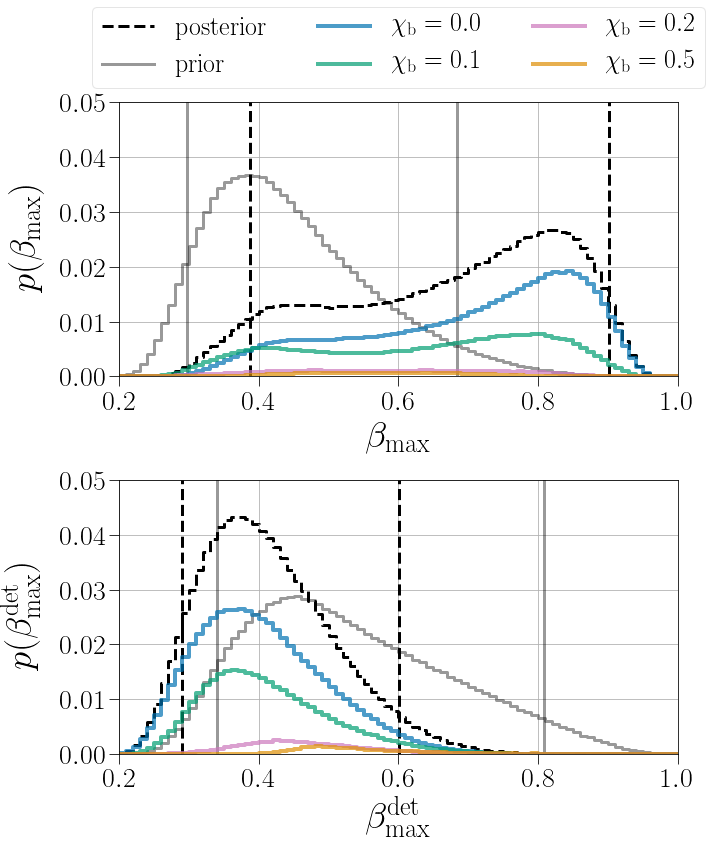

In [13]:
largest_beta(samples, samples_detectable, 0, \
            prior_path='/Users/michaelzevin/research/model_selection/model_selection/data/beta_prior/prior_samples_5channel.hdf5', \
            labelsize=37, ticksize=28, legendsize=26)

### Posterior on the number of channels whose branching fractions are simultaneously above some threshold

In [14]:
def print_significant_contribution(samples, threshold=0.1, param_dict={'p0':None, 'p1':None}):
    
    beta_keys = [key for key in samples.keys() if 'beta' in key]
    
    # cut the samples, if specified, otherwise marginalize over all params
    for key, val in param_dict.items():
        if param_dict[key] is not None:
            samples = samples.loc[samples[key]==val]
            
    N_gtr_thresh = np.asarray(np.sum(samples[beta_keys] > threshold, axis=1))
    
    # print percentages for each
    for i in (np.arange(len(beta_keys))+1):
        Nsamps = np.sum(N_gtr_thresh==i)
        print('Percentage of samples where {:d} channels have branching fractions greater than {:0.3f}: {:0.3f}'.format(i, threshold, 100*(Nsamps/len(samples))))

In [15]:
print_significant_contribution(samples, threshold=0.1, param_dict={'p0':None, 'p1':None})

Percentage of samples where 1 channels have branching fractions greater than 0.100: 26.455
Percentage of samples where 2 channels have branching fractions greater than 0.100: 39.463
Percentage of samples where 3 channels have branching fractions greater than 0.100: 29.798
Percentage of samples where 4 channels have branching fractions greater than 0.100: 4.002
Percentage of samples where 5 channels have branching fractions greater than 0.100: 0.282


In [16]:
print_significant_contribution(samples_detectable, threshold=0.1, param_dict={'p0':None, 'p1':None})

Percentage of samples where 1 channels have branching fractions greater than 0.100: 0.178
Percentage of samples where 2 channels have branching fractions greater than 0.100: 10.409
Percentage of samples where 3 channels have branching fractions greater than 0.100: 38.767
Percentage of samples where 4 channels have branching fractions greater than 0.100: 40.108
Percentage of samples where 5 channels have branching fractions greater than 0.100: 10.537


### Table for Bayes Factors

In [17]:
p1_dict = {0:'0.2', 1:'0.5', 2:'1.0', 3:'2.0', 4:'5.0'}

def construct_table(models, model0_dict):
    
    table = \
r'''\begin{table}[t]
\begin{center}
\caption{Log Bayes factors $\log_{10}(\mathcal{B})$ across \chib models (columns) and \alphaCE models (rows). 
Log Bayes factors are normalized against $\alphaCE=1.0$ and $\chib=0.0$ in the general case, against $\chib=0.0$ when marginalizing over \alphaCE, and against $\alphaCE=1.0$ when marginalizing over \chib. 
The bottom row provides the log Bayes factors for \chib models marginalized over all \alphaCE models, and the rightmost column provides the log Bayes factors for \alphaCE models marginalized over all \chib models. 
%Bayes factors are marked as `$-$' when no samples are in the given model, implying a strongly negative Bayes factor of $\log_{10}(\mathcal{B}) < -4.68$. 
\label{tab:table}}
\setlength{\tabcolsep}{6pt}
\vspace{-10pt}
\begin{tabular}{c c c c c c c} 
& & \multicolumn{4}{c}{$\chi_{\rm b}$} & \\
& \multicolumn{1}{l|}{} & $0.0$ & $0.1$ & $0.2$ & \multicolumn{1}{l|}{$0.5$} & \\
\cline{2-7}
'''
    p0_vals = [0,1,2,3]
    p1_vals = [0,1,2,3,4]
    
    Nsamps0 = len(samples.loc[(samples['p0']==model0_dict['p0']) & (samples['p1']==model0_dict['p1'])])
    Nsamps0_p0 = len(samples.loc[samples['p0']==model0_dict['p0']])
    Nsamps0_p1 = len(samples.loc[samples['p1']==model0_dict['p1']])
    
    for p1 in p1_vals:
        BF_vals = []
        # add values for each alphaCE
        for p0 in p0_vals:
            Nsamps = len(samples.loc[(samples['p0']==p0) & (samples['p1']==p1)])
            if Nsamps == 0:
                BF_vals.append(-100)
            else:
                BF_vals.append(np.log10(Nsamps/Nsamps0))
        # add value for this row in alphaCE
        Nsamps = len(samples.loc[(samples['p1']==p1)])
        if Nsamps == 0:
            BF_vals.append(-100)
        else:
            BF_vals.append(np.log10(Nsamps/Nsamps0_p1))
        
        # reformat the BF values
        BF_vals_formatted = []
        for BF in BF_vals:
            if BF==0:
                BF_vals_formatted.append(r'\equiv0')
            elif BF==-100:
                BF_vals_formatted.append('-')
            else:
                BF_vals_formatted.append('{:0.2f}'.format(np.round(BF, 2)))
        
        if p1 == 0:
            temp = r'''\multirow{5}{*}{$\alpha_{\rm CE}$} & \multicolumn{1}{l|}{$%s$} & $%s$ & $%s$ & $%s$ & \multicolumn{1}{l|}{$%s$} & $%s$ \\
''' % (p1_dict[p1], BF_vals_formatted[0], BF_vals_formatted[1], BF_vals_formatted[2], \
                                   BF_vals_formatted[3], BF_vals_formatted[4])
        else:
            temp = r'''& \multicolumn{1}{l|}{$%s$} & $%s$ & $%s$ & $%s$ & \multicolumn{1}{l|}{$%s$} & $%s$ \\
''' % (p1_dict[p1], BF_vals_formatted[0], BF_vals_formatted[1], BF_vals_formatted[2], \
                                   BF_vals_formatted[3], BF_vals_formatted[4])
        table += temp

    table += r'''\cline{2-7}
'''
    
    # add values for all chib columns
    BF_vals = []
    for p0 in p0_vals:
        Nsamps = len(samples.loc[(samples['p0']==p0)])
        if Nsamps == 0:
            BF_vals.append(-100)
        else:
            BF_vals.append(np.log10(Nsamps/Nsamps0_p0))
    BF_vals_formatted = []
    for BF in BF_vals:
        if BF==0:
            BF_vals_formatted.append(r'\equiv0')
        elif BF==-100:
            BF_vals_formatted.append('-')
        else:
            BF_vals_formatted.append('{:0.2f}'.format(np.round(BF, 2)))
    temp = r'''& \multicolumn{1}{l|}{$%s$} & $%s$ & $%s$ & $%s$ & \multicolumn{1}{l|}{$%s$} & $%s$ ''' \
            % ('', BF_vals_formatted[0], BF_vals_formatted[1], BF_vals_formatted[2], BF_vals_formatted[3], '')
    table += temp

    temp = r'''
\end{tabular}
\end{center}
\end{table}'''
    table += temp

    print(str(table))
    return

In [18]:
construct_table(samples, {'p0':0, 'p1':2})

\begin{table}[t]
\begin{center}
\caption{Log Bayes factors $\log_{10}(\mathcal{B})$ across \chib models (columns) and \alphaCE models (rows). 
Log Bayes factors are normalized against $\alphaCE=1.0$ and $\chib=0.0$ in the general case, against $\chib=0.0$ when marginalizing over \alphaCE, and against $\alphaCE=1.0$ when marginalizing over \chib. 
The bottom row provides the log Bayes factors for \chib models marginalized over all \alphaCE models, and the rightmost column provides the log Bayes factors for \alphaCE models marginalized over all \chib models. 
%Bayes factors are marked as `$-$' when no samples are in the given model, implying a strongly negative Bayes factor of $\log_{10}(\mathcal{B}) < -4.68$. 
\label{tab:table}}
\setlength{\tabcolsep}{6pt}
\vspace{-10pt}
\begin{tabular}{c c c c c c c} 
& & \multicolumn{4}{c}{$\chi_{\rm b}$} & \\
& \multicolumn{1}{l|}{} & $0.0$ & $0.1$ & $0.2$ & \multicolumn{1}{l|}{$0.5$} & \\
\cline{2-7}
\multirow{5}{*}{$\alpha_{\rm CE}$} & \multicolumn

### Isolated versus Dynamical Branching Fractions

In [19]:
def isodyn_branching_fractions(samples, detectable_samples, hyperidx, log=False, labelsize=30, ticksize=20, legendsize=35):
    beta_keys = sorted([key for key in list(samples.keys()) if 'beta' in key])
    hyperidx_col = 'p'+str(int(hyperidx))

    fig, axs = plt.subplots(2,2, figsize=(10,8))
    
    for axidx, (samps, subaxs) in enumerate(zip([samples, detectable_samples], [axs[0,:], axs[1,:]])):
        print("")
        if axidx==0:
            print('UNDERLYING')
        elif axidx==1:
            print('DETECTABLE')

        # loop through hyperparameter values
        for (hkey, hval) in hyperparam_dict[hyperidx_col].items():
            samples_in_hypermodel = samps.loc[samps[hyperidx_col]==hkey]

            # get dynamical betas
            iso_betas = np.asarray(samples_in_hypermodel['beta_CE'] + samples_in_hypermodel['beta_CHE'] + samples_in_hypermodel['beta_SMT'])
            dyn_betas = np.asarray(samples_in_hypermodel['beta_GC'] + samples_in_hypermodel['beta_NSC'])

            h, bins = np.histogram(iso_betas, bins=100, range=(0,1))
            h = np.append(h, [0])
            if axidx==0:
                subaxs[0].step(bins, h/len(samps), lw=4, alpha=0.5, color=colors[hkey], label=hval)
            else:
                subaxs[0].step(bins, h/len(samps), lw=4, alpha=0.5, color=colors[hkey])

            h, bins = np.histogram(dyn_betas, bins=100, range=(0,1))
            h = np.append(h, [0])
            subaxs[1].step(bins, h/len(samps), lw=4, alpha=0.5, color=colors[hkey])
            
            # print info
            median = np.median(iso_betas)
            low90 = np.percentile(iso_betas,5)
            high90 = np.percentile(iso_betas,95)
            print("   Field ({:s}): {:0.3f}-{:0.3f}+{:0.3f}".format(hval, median, median-low90, high90-median))
            median = np.median(dyn_betas)
            low90 = np.percentile(dyn_betas,5)
            high90 = np.percentile(dyn_betas,95)
            print("   Dynamical ({:s}): {:0.3f}-{:0.3f}+{:0.3f}".format(hval, median, median-low90, high90-median))


        # plot total branching fraction
        iso_betas = np.asarray(samps['beta_CE'] + samps['beta_CHE'] + samps['beta_SMT'])
        dyn_betas = np.asarray(samps['beta_GC'] + samps['beta_NSC'])

        h, bins = np.histogram(iso_betas, bins=100, range=(0,1))
        h = np.append(h, [0])
        subaxs[0].step(bins, h/len(samps), color='k', alpha=1.0, lw=3, linestyle='--')

        h, bins = np.histogram(dyn_betas, bins=100, range=(0,1))
        h = np.append(h, [0])
        subaxs[1].step(bins, h/len(samps), color='k', alpha=1.0, lw=3, linestyle='--')
        
        # print info
        median = np.median(iso_betas)
        low90 = np.percentile(iso_betas,5)
        high90 = np.percentile(iso_betas,95)
        print("     Total Field: {:0.3f}-{:0.3f}+{:0.3f}".format(median, median-low90, high90-median))
        median = np.median(dyn_betas)
        low90 = np.percentile(dyn_betas,5)
        high90 = np.percentile(dyn_betas,95)
        print("     Total Dynamical: {:0.3f}-{:0.3f}+{:0.3f}".format(median, median-low90, high90-median))

            
        # format plot
        for idx, ax in enumerate(subaxs):

            ax.set_xlim(0,1)
            ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
            ax.set_xticklabels([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=ticksize)

            ax.set_yscale('log')
            ax.set_ylim(1e-5, 1e-1)
            ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
            ax.set_yticklabels(['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=ticksize)

            if axidx==0:
                ax.set_xticklabels([])
            elif axidx==1:
                if idx==0:
                    ax.set_xlabel(r'$\beta_\mathrm{field}$', fontsize=labelsize)
                elif idx==1:
                    ax.set_xlabel((r'$\beta_\mathrm{dynamical}$'), fontsize=labelsize)

            if idx==0:
                if axidx==0:
                    ax.set_ylabel(r'$p(\beta)$')
                elif axidx==1:
                    ax.set_ylabel(r'$p(\beta^\mathrm{det})$')
            else:
                ax.set_yticklabels([])
        
    # legend
    if hyperidx_col=='p0':
        fig.legend(bbox_to_anchor=(0.55, 0.91), loc='center', ncol=2, prop={'size':legendsize})
    elif hyperidx_col=='p1':
        fig.legend(bbox_to_anchor=(0.55, 1.2), loc='center', ncol=len(hyperparam_dict[hyperidx_col].keys()), prop={'size':legendsize})
        
    plt.tight_layout(rect=(0.0,0,1,0.85))
    plt.savefig(os.path.join(fig_path, 'field_dynamical.png'), dpi=200)


UNDERLYING
   Field ($\chi_\mathrm{b}=0.0$): 0.894-0.190+0.073
   Dynamical ($\chi_\mathrm{b}=0.0$): 0.106-0.073+0.190
   Field ($\chi_\mathrm{b}=0.1$): 0.789-0.297+0.137
   Dynamical ($\chi_\mathrm{b}=0.1$): 0.211-0.137+0.297
   Field ($\chi_\mathrm{b}=0.2$): 0.660-0.347+0.201
   Dynamical ($\chi_\mathrm{b}=0.2$): 0.340-0.201+0.347
   Field ($\chi_\mathrm{b}=0.5$): 0.183-0.119+0.272
   Dynamical ($\chi_\mathrm{b}=0.5$): 0.817-0.272+0.119
     Total Field: 0.857-0.363+0.105
     Total Dynamical: 0.143-0.105+0.363

DETECTABLE
   Field ($\chi_\mathrm{b}=0.0$): 0.576-0.227+0.195
   Dynamical ($\chi_\mathrm{b}=0.0$): 0.424-0.195+0.227
   Field ($\chi_\mathrm{b}=0.1$): 0.387-0.179+0.208
   Dynamical ($\chi_\mathrm{b}=0.1$): 0.613-0.208+0.179
   Field ($\chi_\mathrm{b}=0.2$): 0.243-0.126+0.168
   Dynamical ($\chi_\mathrm{b}=0.2$): 0.757-0.168+0.126
   Field ($\chi_\mathrm{b}=0.5$): 0.099-0.062+0.101
   Dynamical ($\chi_\mathrm{b}=0.5$): 0.901-0.101+0.062
     Total Field: 0.496-0.299+0.248


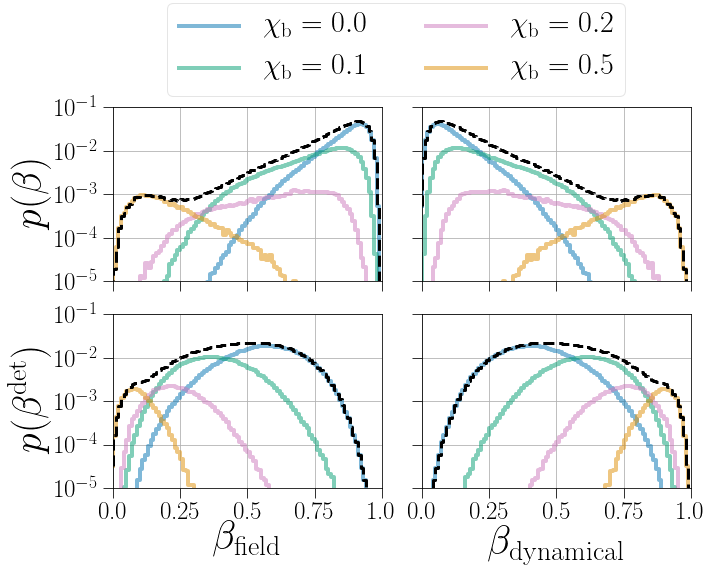

In [20]:
isodyn_branching_fractions(samples, samples_detectable, 0, log=True, labelsize=40, ticksize=25, legendsize=30)

### Mock Samples

In [21]:
data_path = '/Users/michaelzevin/research/model_selection/model_selection/trials/chi00_alpha10_delta'
Nobs = sorted([int(n) for n in os.listdir(data_path)])

In [22]:
# Branching fractions

def branching_fractions_mockobs(hyperidx, Nobs):
    
    if hyperidx==0:
        colors_tmp = colors[:4]
    elif hyperidx==1:
        colors_tmp = colors[4:][::-1]
    
    # plotting
    fig, axs = plt.subplots(len(Nobs),5, figsize=(4*5,4*len(Nobs)))
    
    for sidx, (subaxs, N) in enumerate(zip(axs, Nobs)):
    
        # get the hdf5 files for this run
        run_files = os.listdir(os.path.join(data_path, str(N)))
        sample_files = []
        for file in run_files:
            if '.hdf5' in file:
                sample_files.append(file)

        samples = pd.DataFrame()

        for fidx, file in enumerate(sample_files):
            if fidx==0:
                # save model0 info, assuming all in this folder are the same
                f = h5py.File(os.path.join(data_path, str(N), file))
                model0_info = f['model_selection'].attrs['model0_params']
                f.close()
            tmp = pd.read_hdf(os.path.join(data_path, str(N), file), key='model_selection/detectable_samples')
            samples = samples.append(tmp)

        samples = samples.reset_index(drop=True)

        beta_keys = sorted([key for key in list(samples.keys()) if 'beta' in key])
        hyperidx_col = 'p'+str(int(hyperidx))


        # store true values in dict
        beta_true = {}
        for beta in beta_keys:
            for hyperp in list(model0_info):
                if beta[-2:] in str(hyperp):
                    beta_true[beta] = float(hyperp[-3:])


        # loop through hyperparameter values
        for (hkey, hval) in hyperparam_dict[hyperidx_col].items():
            samples_in_hypermodel = samples.loc[samples[hyperidx_col]==hkey]

            # loops through channels
            for cidx, beta in enumerate(beta_keys):
                if cidx==0:
                    _ = subaxs[cidx].hist(samples_in_hypermodel[beta], bins=50, histtype='step', range=(0,1), lw=4, alpha=0.5, color=colors_tmp[hkey], label=hval)
                else:
                    _ = subaxs[cidx].hist(samples_in_hypermodel[beta], bins=50, histtype='step', range=(0,1), lw=4, alpha=0.5, color=colors_tmp[hkey])
                if hkey==0:
                    subaxs[cidx].axvline(beta_true[beta], color='k', linestyle='--')



        # format plot
        for idx, ax in enumerate(subaxs):
            ax.set_xlim(0,1)
            ax.set_xticks((0.0, 0.5, 1.0))
            ax.set_yscale('log')
            ax.set_ylim(1e0, 2e7)
            ax.set_yticks([1e0, 1e2, 1e4, 1e6])
            if idx!=0:
                ax.set_yticklabels([])
            else:
                ax.set_yticklabels(['$10^0$', '$10^2$', '$10^4$', '$10^6$'])
            if idx==0:
                ax.set_ylabel(r'$N_{\rm obs}$' + ' = %d \n counts' % (N))
            if sidx==len(axs)-1:
                ax.set_xlabel(hyperparam_dict[beta_keys[idx]+'_det'], labelpad=15)
                ax.set_xticklabels([0.0, 0.5, 1.0])
            else:
                ax.set_xticklabels([])
            
        # legend
        if sidx==0:
            if hyperidx_col=='p0':
                fig.legend(bbox_to_anchor=(0.53, 0.97), loc='center', ncol=len(hyperparam_dict[hyperidx_col].keys()), prop={'size':35})
            elif hyperidx_col=='p1':
                fig.legend(bbox_to_anchor=(0.535, 0.97), loc='center', ncol=len(hyperparam_dict[hyperidx_col].keys()), prop={'size':29})
            
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(fig_path, 'mock_samples_'+hyperidx_col+'.png'), dpi=200)

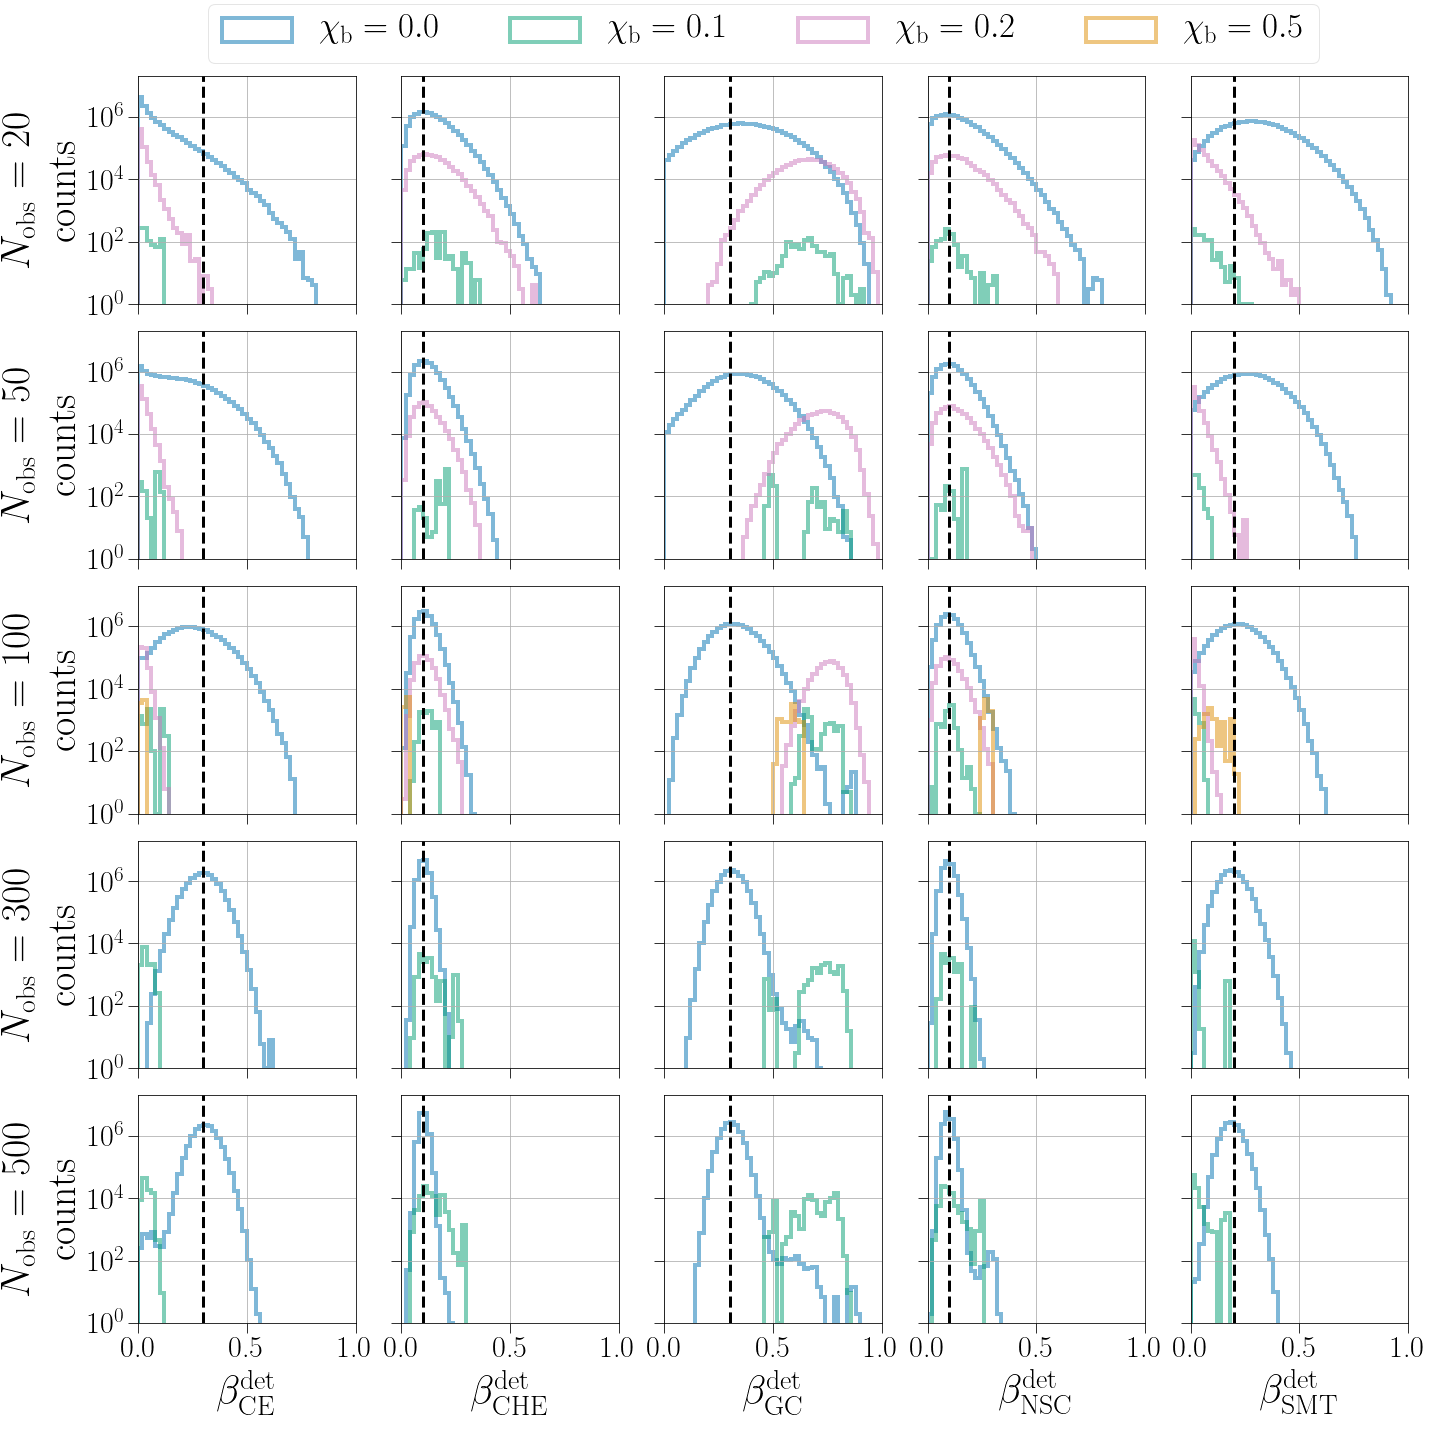

In [23]:
branching_fractions_mockobs(0, Nobs)

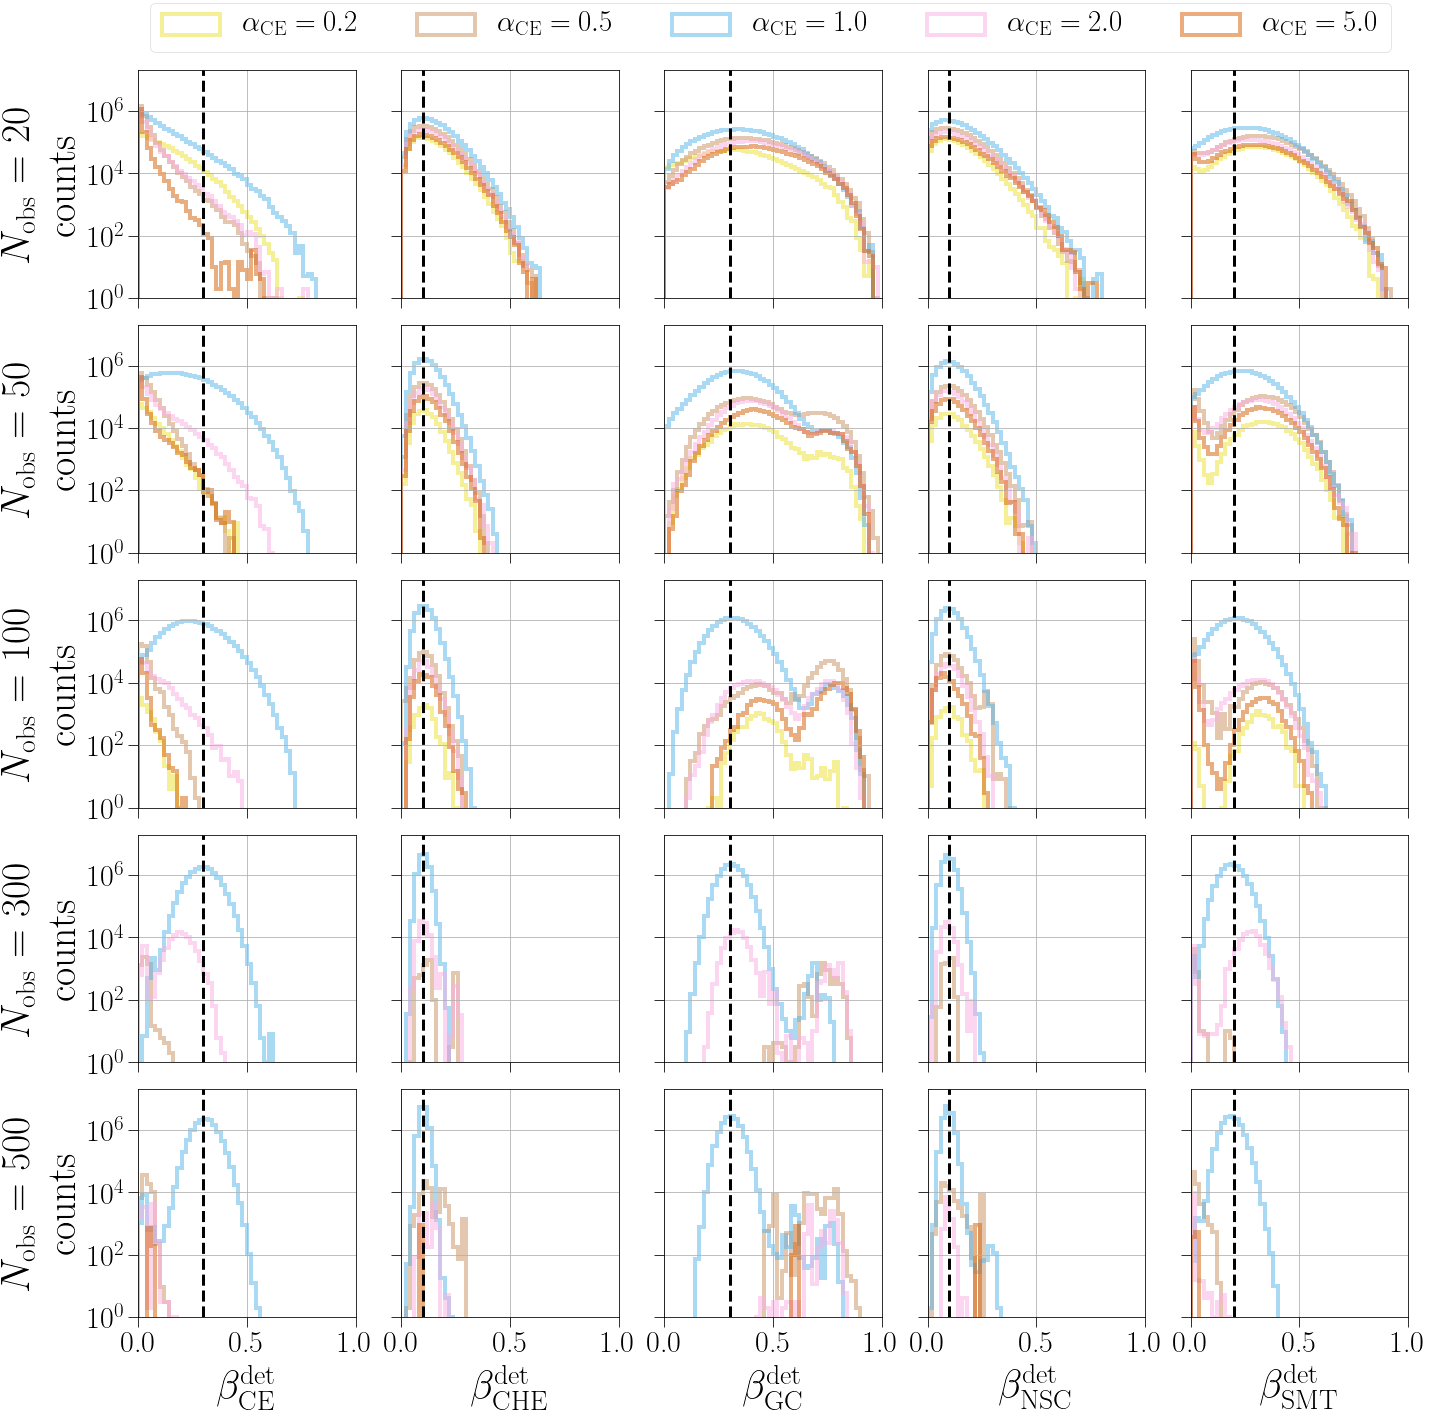

In [24]:
branching_fractions_mockobs(1, Nobs)